# Setup

In [1]:
# General libraries
import pandas as pd
import numpy as np

# Utilities
from pathlib import Path
import psutil
import gc
import os

# Cuda
import torch

In [2]:
# Warnings
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Suppress the specific PerformanceWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Pd options
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [3]:
# Get the number of available CPUs
num_cpus = os.cpu_count()

# Show
print(num_cpus)

8


In [4]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


# Directory

In [5]:
# Set the right directory
current_path = Path.cwd()
if current_path.name in ['notebooks', 'src']:
    os.chdir('..')
    print(f"Moved up from {current_path.name} to: {os.getcwd()}")
else:
    print(f"Already in project directory: {os.getcwd()}")

Moved up from notebooks to: /Users/ignasipascual/Documents/GitHub/Forecaster


# Assets

## Import assets

In [6]:
# Import assets
from utils.forecaster import Forecaster
from utils.evaluator import Evaluator
from utils.auxiliar import *

# Load data

In [7]:
# Load from data folder
file_name = f'data/df_backtesting.csv'

# Load the CSV into a DataFrame
df_input = pd.read_csv(file_name)

# Show
df_input.head()

,reporterhq_id,product_number,prod_category,specs,display_size,segment,date,sales_units,inventory_units,filled_sales_units,filled_inventory_units,cutoff,sample,feature_reporterhq_id,feature_product_number,feature_prod_category,feature_specs,feature_display_size,feature_segment,feature_periods,feature_periods_expanding,feature_periods_sqrt,feature_year,feature_quarter,feature_month,feature_week,feature_day,feature_dayofweek,feature_sin_yearly_1,feature_cos_yearly_1,feature_sin_yearly_2,feature_cos_yearly_2,feature_sin_yearly_3,feature_cos_yearly_3,feature_sin_quarterly_1,feature_cos_quarterly_1,feature_sin_quarterly_2,feature_cos_quarterly_2,feature_sin_monthly_1,feature_cos_monthly_1,feature_sin_monthly_2,feature_cos_monthly_2,feature_sin_weekly_1,feature_cos_weekly_1,feature_sin_weekly_2,feature_cos_weekly_2,feature_sin_weekly_3,feature_cos_weekly_3,feature_days_until_end_of_month,feature_days_until_end_of_week,feature_days_until_end_of_quarter,feature_days_until_end_of_year,feature_weeks_until_end_of_month,feature_weeks_until_end_of_quarter,feature_weeks_until_end_of_year,feature_months_until_end_of_quarter,feature_months_until_end_of_year,filled_sales_units_ma_4,filled_sales_units_ma_13,filled_inventory_units_ma_4,filled_inventory_units_ma_13,filled_sales_units_min_4,filled_sales_units_max_4,filled_sales_units_min_13,filled_sales_units_max_13,filled_inventory_units_min_4,filled_inventory_units_max_4,filled_inventory_units_min_13,filled_inventory_units_max_13,feature_filled_sales_units_lag_13,feature_filled_sales_units_lag_52,feature_filled_inventory_units_lag_13,feature_filled_inventory_units_lag_52,feature_filled_sales_units_ma_4_lag_13,feature_filled_sales_units_ma_4_lag_52,feature_filled_sales_units_ma_13_lag_13,feature_filled_sales_units_ma_13_lag_52,feature_filled_inventory_units_ma_4_lag_13,feature_filled_inventory_units_ma_4_lag_52,feature_filled_inventory_units_ma_13_lag_13,feature_filled_inventory_units_ma_13_lag_52,feature_filled_sales_units_min_4_lag_13,feature_filled_sales_units_min_4_lag_52,feature_filled_sales_units_max_4_lag_13,feature_filled_sales_units_max_4_lag_52,feature_filled_sales_units_min_13_lag_13,feature_filled_sales_units_min_13_lag_52,feature_filled_sales_units_max_13_lag_13,feature_filled_sales_units_max_13_lag_52,feature_filled_inventory_units_min_4_lag_13,feature_filled_inventory_units_min_4_lag_52,feature_filled_inventory_units_max_4_lag_13,feature_filled_inventory_units_max_4_lag_52,feature_filled_inventory_units_min_13_lag_13,feature_filled_inventory_units_min_13_lag_52,feature_filled_inventory_units_max_13_lag_13,feature_filled_inventory_units_max_13_lag_52,feature_filled_inventory_units_cov,feature_distinct_product_number_reporterhq_id,feature_distinct_product_number_cutoff,feature_filled_sales_units_cluster,feature_filled_inventory_units_cluster,feature_filled_sales_units_history_cluster,feature_filled_inventory_units_history_cluster,feature_intermittence_filled_sales_units_cluster,feature_intermittence_filled_inventory_units_cluster,train_weight,fcst_lag,feature_baseline_filled_sales_units_ma_13,feature_baseline_filled_inventory_units_ma_13,baseline_filled_sales_units_ma_13,baseline_filled_inventory_units_ma_13
0,12,10857,Doraemon,108304,15.6,Gaming,2021-01-30,0.0,52.0,0.0,52.0,2023-02-04,train,0,7,4,9,6,1,1.0,1.00,1.00,2021,1,1,4,30,5,0.49,0.87,0.86,0.51,1.00,0.02,0.88,-0.47,-0.83,-0.55,-0.20,0.98,-0.39,0.92,-0.97,-0.22,0.43,-0.9,0.78,0.62,1,1,60,335,0.14,8.57,47.86,2.0,11.0,0.00,0.00,52.00,52.00,0.0,0.0,0.0,0.0,52.0,52.0,52.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,2,4,5,10,4,12,9,1,0.01,0,0.00,52.00,NaN,NaN
1,12,10857,Doraemon,108304,15.6,Gaming,2021-02-06,8.0,48.0,8.0,48.0,2023-02-04,train,0,7,4,9,6,1,2.0,2.14,1.41,2021,1,2,5,6,5,0.59,0.80,0.96,0.29,0.94,-0.33,0.56,-0.83,-0.93,0.37,0.97,0.22,0.43,-0.90,-0.97,-0.22,0.43,-0.9,0.78,0.62,22,1,53,328,3.14,7.57,46.86,1.0,10.0,4.00,4.00,50.00,50.00,0.0,8.0,0.

## Statistics

In [8]:
# Find duplicate column names
duplicate_columns = df_input.columns[df_input.columns.duplicated()].tolist()

# Show
print("Duplicate column names:", duplicate_columns)

Duplicate column names: []


In [9]:
# Check if any column is completely filled with NaN values
na_columns = df_input.columns[df_input.isna().all()].tolist()

# Show
print("Columns full of NaN values:", na_columns)

Columns full of NaN values: []


In [10]:
# Show data types
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107134 entries, 0 to 107133
Columns: 112 entries, reporterhq_id to baseline_filled_inventory_units_ma_13
dtypes: float64(79), int64(28), object(5)
memory usage: 91.5+ MB


# Forecasting model

## Features

In [11]:
# Automatically find all feature columns containing 'feature' in their names
features = [col for col in df_input.columns if "feature" in col]

# Create default trainining group
df_input['training_group'] = 1

# Show
features

['feature_reporterhq_id',
 'feature_product_number',
 'feature_prod_category',
 'feature_specs',
 'feature_display_size',
 'feature_segment',
 'feature_periods',
 'feature_periods_expanding',
 'feature_periods_sqrt',
 'feature_year',
 'feature_quarter',
 'feature_month',
 'feature_week',
 'feature_day',
 'feature_dayofweek',
 'feature_sin_yearly_1',
 'feature_cos_yearly_1',
 'feature_sin_yearly_2',
 'feature_cos_yearly_2',
 'feature_sin_yearly_3',
 'feature_cos_yearly_3',
 'feature_sin_quarterly_1',
 'feature_cos_quarterly_1',
 'feature_sin_quarterly_2',
 'feature_cos_quarterly_2',
 'feature_sin_monthly_1',
 'feature_cos_monthly_1',
 'feature_sin_monthly_2',
 'feature_cos_monthly_2',
 'feature_sin_weekly_1',
 'feature_cos_weekly_1',
 'feature_sin_weekly_2',
 'feature_cos_weekly_2',
 'feature_sin_weekly_3',
 'feature_cos_weekly_3',
 'feature_days_until_end_of_month',
 'feature_days_until_end_of_week',
 'feature_days_until_end_of_quarter',
 'feature_days_until_end_of_year',
 'feature_wee

In [12]:
# Number of features
print("Number of features:", len(features))

Number of features: 83


## Hyperparameters

In [13]:
# Define parameter dictionary
hyperparam_dictionary = {
    'LGBM': {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [500, 1000, 2000],
        'num_leaves': [15, 31, 64],
        'max_depth': [4, 8, 12],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0.0, 0.1, 0.5],
        'reg_lambda': [0.0, 0.1, 0.5]
    }
}

# Calculate the number of combinations
num_combinations = (
    len(hyperparam_dictionary['LGBM']['learning_rate']) *
    len(hyperparam_dictionary['LGBM']['n_estimators']) *
    len(hyperparam_dictionary['LGBM']['num_leaves']) *
    len(hyperparam_dictionary['LGBM']['max_depth']) *
    len(hyperparam_dictionary['LGBM']['subsample']) *
    len(hyperparam_dictionary['LGBM']['colsample_bytree']) *
    len(hyperparam_dictionary['LGBM']['reg_alpha']) *
    len(hyperparam_dictionary['LGBM']['reg_lambda'])
)

# Print the number of potential combinations
print(f"Number of potential combinations for Grid Search: {num_combinations:,}")

Number of potential combinations for Grid Search: 6,561


## Configuration

In [14]:
# Parameters
group_cols = ['reporterhq_id', 'product_number']
training_group = 'training_group'
target_col = 'filled_inventory_units'
model = 'LGBM'
tune_hyperparameters = False
search_method = 'halving'
default_params = None
param_distributions = hyperparam_dictionary
scoring_metric = 'neg_root_mean_squared_error'
n_iter = 50
best_features = False
n_best_features = 25
use_weights = True

# Outliers
remove_outliers = True
outlier_column = 'filled_inventory_units'
lower_quantile = 0.025
upper_quantile = 0.975
ts_decomposition = False

# Guardrail
baseline_col = 'baseline_filled_inventory_units_ma_13'
use_guardrail = True
guardrail_limit = 2.5

# Parallel
use_parallel = False
num_cpus = 5

## Run Predictor

In [15]:
%%time
# Initialize the Forecaster class with df_input
forecaster = Forecaster(df_input)

# Call the function
df_with_preds = forecaster.run_backtesting(
    group_cols,
    features,
    default_params,
    training_group,
    target_col,
    model,
    tune_hyperparameters,
    search_method,
    param_distributions,
    scoring_metric,
    n_iter,
    best_features,
    n_best_features,
    remove_outliers,
    outlier_column,
    lower_quantile,
    upper_quantile,
    ts_decomposition,
    baseline_col,
    use_guardrail,
    guardrail_limit,
    use_weights,
    use_parallel,
    num_cpus
)

Starting backtesting
User did not provide parameter dictionary, using internal method
Number of cutoffs detected:  4
CUDA is not available, using CPU with 8 available cores
Predictions will be generated with model: LGBM
Running predictions sequentially
----------------------------------------------------------

Processing cutoff 1/4 (25.00%) - Cutoff: 2023-02-04
----------------------------------------------------------
No feature selection: Using all features provided
Training and predicting for cutoff: 2023-02-04, training group: 1 (100.00% of groups in cutoff)
Using heuristic parameters for cutoff: 2023-02-04, training group: 1 (training_group)
Heuristic parameters for LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, max_depth=9,
              n_estimators=1000, n_jobs=-1, num_leaves=127,
              objective='regression', random_state=42, reg_alpha=0.03,
              reg_lambda=0.05, subsample=0.8, verbose=-1):
Calculating guardrail for cutoff: 2023-02-04, training group

## Optimization

In [16]:
# If hyperparameter tuning retrieve best combination
if tune_hyperparameters:

  # Retrieve and print the best hyperparameters for each cutoff
  best_hyperparams = forecaster.get_best_hyperparams()
  print("Best Hyperparameters for each cutoff:")

  # Show
  for cutoff, params in best_hyperparams.items():
      print(f"Cutoff {cutoff}: {params}")

## Guardrail

In [17]:
# If guardrail is activated
if use_guardrail:
  # Assuming 'df_with_preds' is the DataFrame
  group_cols = ['reporterhq_id', 'product_number', 'cutoff']

  # Group by the specified columns and check for at least one True in each group
  guardrail_groups =  df_with_preds.groupby(group_cols)['guardrail'].any().reset_index()

  # Calculate the total number of groups
  total_groups = guardrail_groups.shape[0]

  # Count the number of groups where guardrail is True
  true_guardrail_groups_count = guardrail_groups['guardrail'].sum()

  # Calculate the percentage of groups with guardrail == True
  percentage_guardrail_true = (true_guardrail_groups_count / total_groups) * 100

  # Show
  print(f"Percentage of groups where guardrail is True: {percentage_guardrail_true:.2f}%")

Percentage of groups where guardrail is True: 0.00%


# Evaluate results

## Feature importance

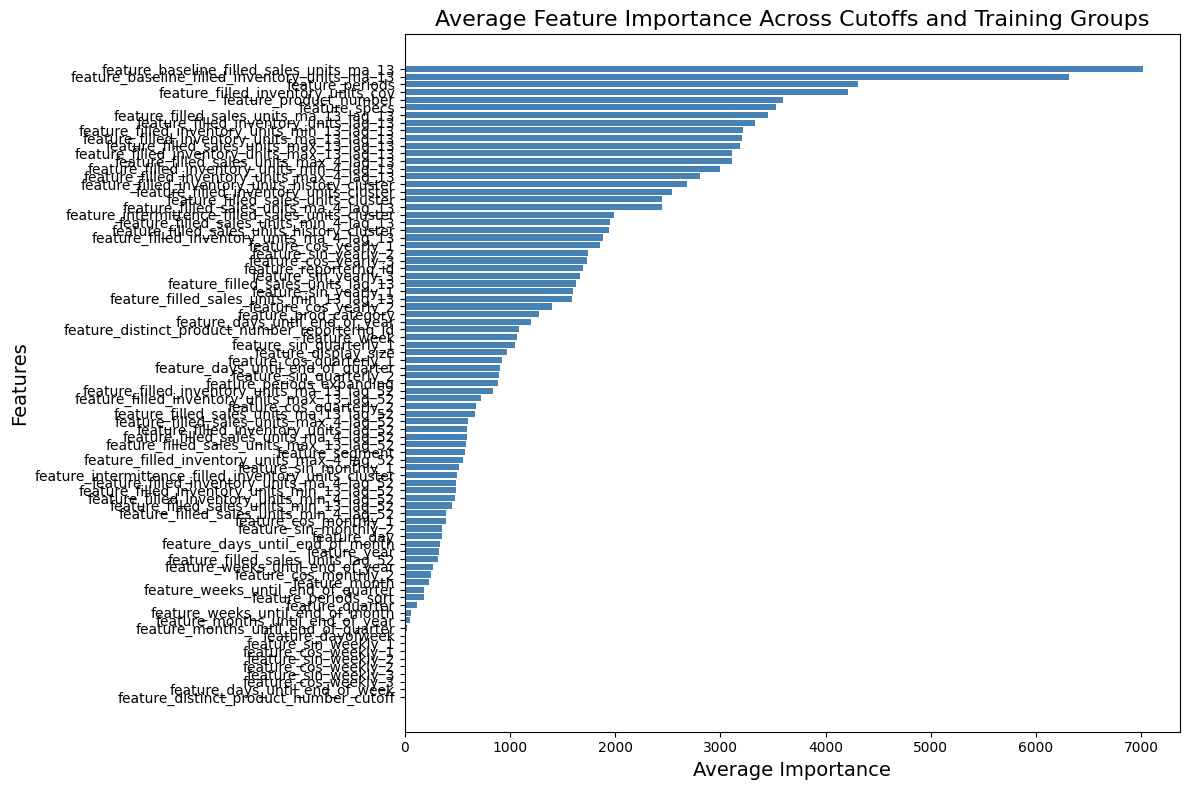

In [18]:
# Plot the average feature importance across all cutoffs
forecaster.plot_feature_importance()

## Run evaluator

In [19]:
# Params
actuals_col = 'inventory_units'
baseline_col = 'baseline_filled_inventory_units_ma_13'
preds_col = ['prediction']

# Initialize the Evaluator class
evaluator = Evaluator(df_with_preds, actuals_col, baseline_col, preds_col)

# Call the function
metric_table = evaluator.create_metric_table()

# Show
metric_table

,RMSE,MAE,MAPE,WMAPE,Custom Metric
baseline_filled_inventory_units_ma_13,56.46,42.36,180.91,59.29,61.46
prediction,54.10,40.31,168.91,56.42,58.26


# Plot predictions


In [20]:
# Get the max cutoff
max_cutoff = df_with_preds['cutoff'].max()

# Filter the DataFrame where cutoff is equal to the max cutoff
df_filtered = df_with_preds[df_with_preds['cutoff'] == max_cutoff]

# Show
df_filtered.head()

,reporterhq_id,product_number,prod_category,specs,display_size,segment,date,sales_units,inventory_units,filled_sales_units,filled_inventory_units,cutoff,sample,feature_reporterhq_id,feature_product_number,feature_prod_category,feature_specs,feature_display_size,feature_segment,feature_periods,feature_periods_expanding,feature_periods_sqrt,feature_year,feature_quarter,feature_month,feature_week,feature_day,feature_dayofweek,feature_sin_yearly_1,feature_cos_yearly_1,feature_sin_yearly_2,feature_cos_yearly_2,feature_sin_yearly_3,feature_cos_yearly_3,feature_sin_quarterly_1,feature_cos_quarterly_1,feature_sin_quarterly_2,feature_cos_quarterly_2,feature_sin_monthly_1,feature_cos_monthly_1,feature_sin_monthly_2,feature_cos_monthly_2,feature_sin_weekly_1,feature_cos_weekly_1,feature_sin_weekly_2,feature_cos_weekly_2,feature_sin_weekly_3,feature_cos_weekly_3,feature_days_until_end_of_month,feature_days_until_end_of_week,feature_days_until_end_of_quarter,feature_days_until_end_of_year,feature_weeks_until_end_of_month,feature_weeks_until_end_of_quarter,feature_weeks_until_end_of_year,feature_months_until_end_of_quarter,feature_months_until_end_of_year,filled_sales_units_ma_4,filled_sales_units_ma_13,filled_inventory_units_ma_4,filled_inventory_units_ma_13,filled_sales_units_min_4,filled_sales_units_max_4,filled_sales_units_min_13,filled_sales_units_max_13,filled_inventory_units_min_4,filled_inventory_units_max_4,filled_inventory_units_min_13,filled_inventory_units_max_13,feature_filled_sales_units_lag_13,feature_filled_sales_units_lag_52,feature_filled_inventory_units_lag_13,feature_filled_inventory_units_lag_52,feature_filled_sales_units_ma_4_lag_13,feature_filled_sales_units_ma_4_lag_52,feature_filled_sales_units_ma_13_lag_13,feature_filled_sales_units_ma_13_lag_52,feature_filled_inventory_units_ma_4_lag_13,feature_filled_inventory_units_ma_4_lag_52,feature_filled_inventory_units_ma_13_lag_13,feature_filled_inventory_units_ma_13_lag_52,feature_filled_sales_units_min_4_lag_13,feature_filled_sales_units_min_4_lag_52,feature_filled_sales_units_max_4_lag_13,feature_filled_sales_units_max_4_lag_52,feature_filled_sales_units_min_13_lag_13,feature_filled_sales_units_min_13_lag_52,feature_filled_sales_units_max_13_lag_13,feature_filled_sales_units_max_13_lag_52,feature_filled_inventory_units_min_4_lag_13,feature_filled_inventory_units_min_4_lag_52,feature_filled_inventory_units_max_4_lag_13,feature_filled_inventory_units_max_4_lag_52,feature_filled_inventory_units_min_13_lag_13,feature_filled_inventory_units_min_13_lag_52,feature_filled_inventory_units_max_13_lag_13,feature_filled_inventory_units_max_13_lag_52,feature_filled_inventory_units_cov,feature_distinct_product_number_reporterhq_id,feature_distinct_product_number_cutoff,feature_filled_sales_units_cluster,feature_filled_inventory_units_cluster,feature_filled_sales_units_history_cluster,feature_filled_inventory_units_history_cluster,feature_intermittence_filled_sales_units_cluster,feature_intermittence_filled_inventory_units_cluster,train_weight,fcst_lag,feature_baseline_filled_sales_units_ma_13,feature_baseline_filled_inventory_units_ma_13,baseline_filled_sales_units_ma_13,baseline_filled_inventory_units_ma_13,training_group,guardrail,prediction
75417,12,10857,Doraemon,108304,15.6,Gaming,2021-01-30,0.0,52.0,0.0,52.0,2023-05-06,train,0,7,4,9,6,1,1.0,1.00,1.00,2021,1,1,4,30,5,0.49,0.87,0.86,0.51,1.00,0.02,0.88,-0.47,-0.83,-0.55,-0.20,0.98,-0.39,0.92,-0.97,-0.22,0.43,-0.9,0.78,0.62,1,1,60,335,0.14,8.57,47.86,2.0,11.0,0.00,0.00,52.00,52.00,0.0,0.0,0.0,0.0,52.0,52.0,52.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.61,2,4,5,10,4,12,9,1,0.01,0,0.00,52.00,NaN,NaN,1,False,NaN
75418,12,10857,Doraemon,108304,15.6,Gaming,2021-02-06,8.0,48.0,8.0,48.0,2023-05-06,train,0,7,4,9,6,1,2.0,2.14,1.41,2021,1,2,5,6,5,0.59,0.80,0.96,0.29,0.94,-0.33,0.56,-0.83,-0.93,0.37,0.97,0.22,0.43,-0.90,-0.97,-0.22,0.43,-0.9,0.78,0.62,22,1,53,328,3

In [21]:
# Params
baseline_col = 'baseline_filled_inventory_units_ma_13'
target_col = 'inventory_units'
top_n_plots = 6

## Plot by Reporter

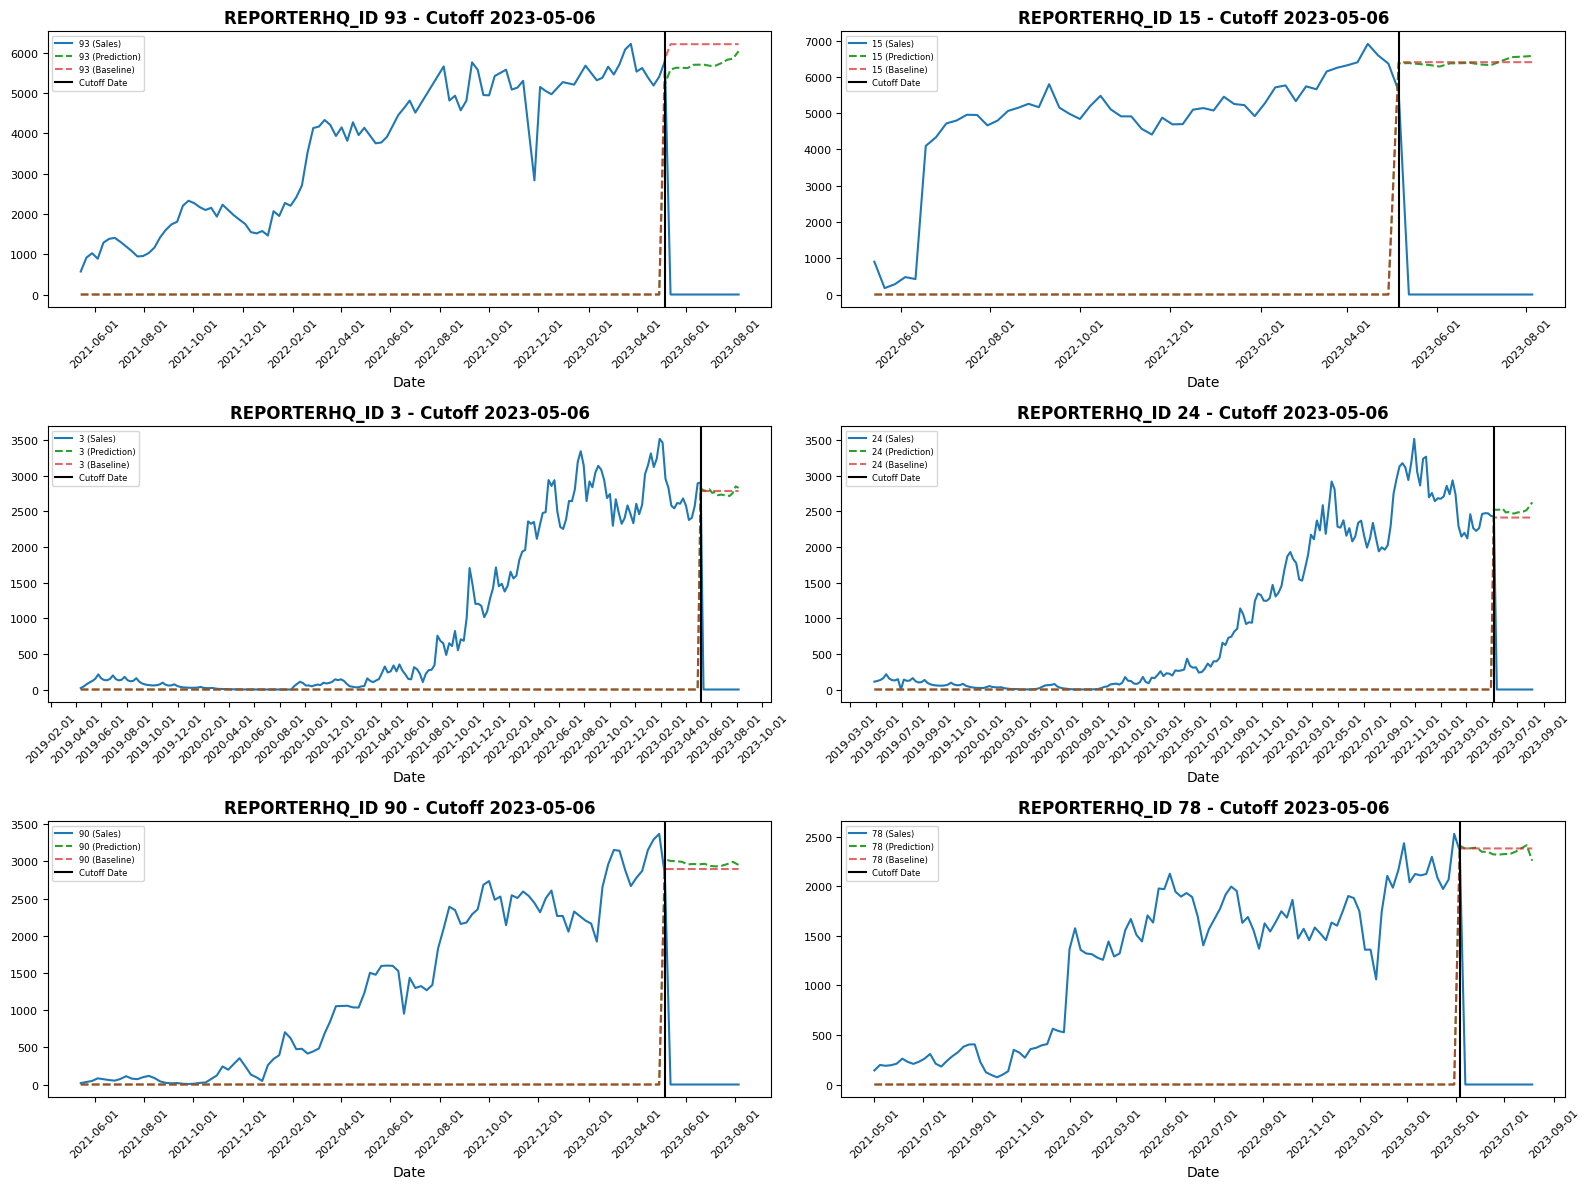

In [22]:
# Plot by client
process_and_plot(
    df_filtered,
    group_col='reporterhq_id',
    baseline_col=baseline_col,
    target_col=target_col,
    top_n=top_n_plots,
    title='Top Reporter Target vs Baseline vs Prediction'
)

## Plot by Product

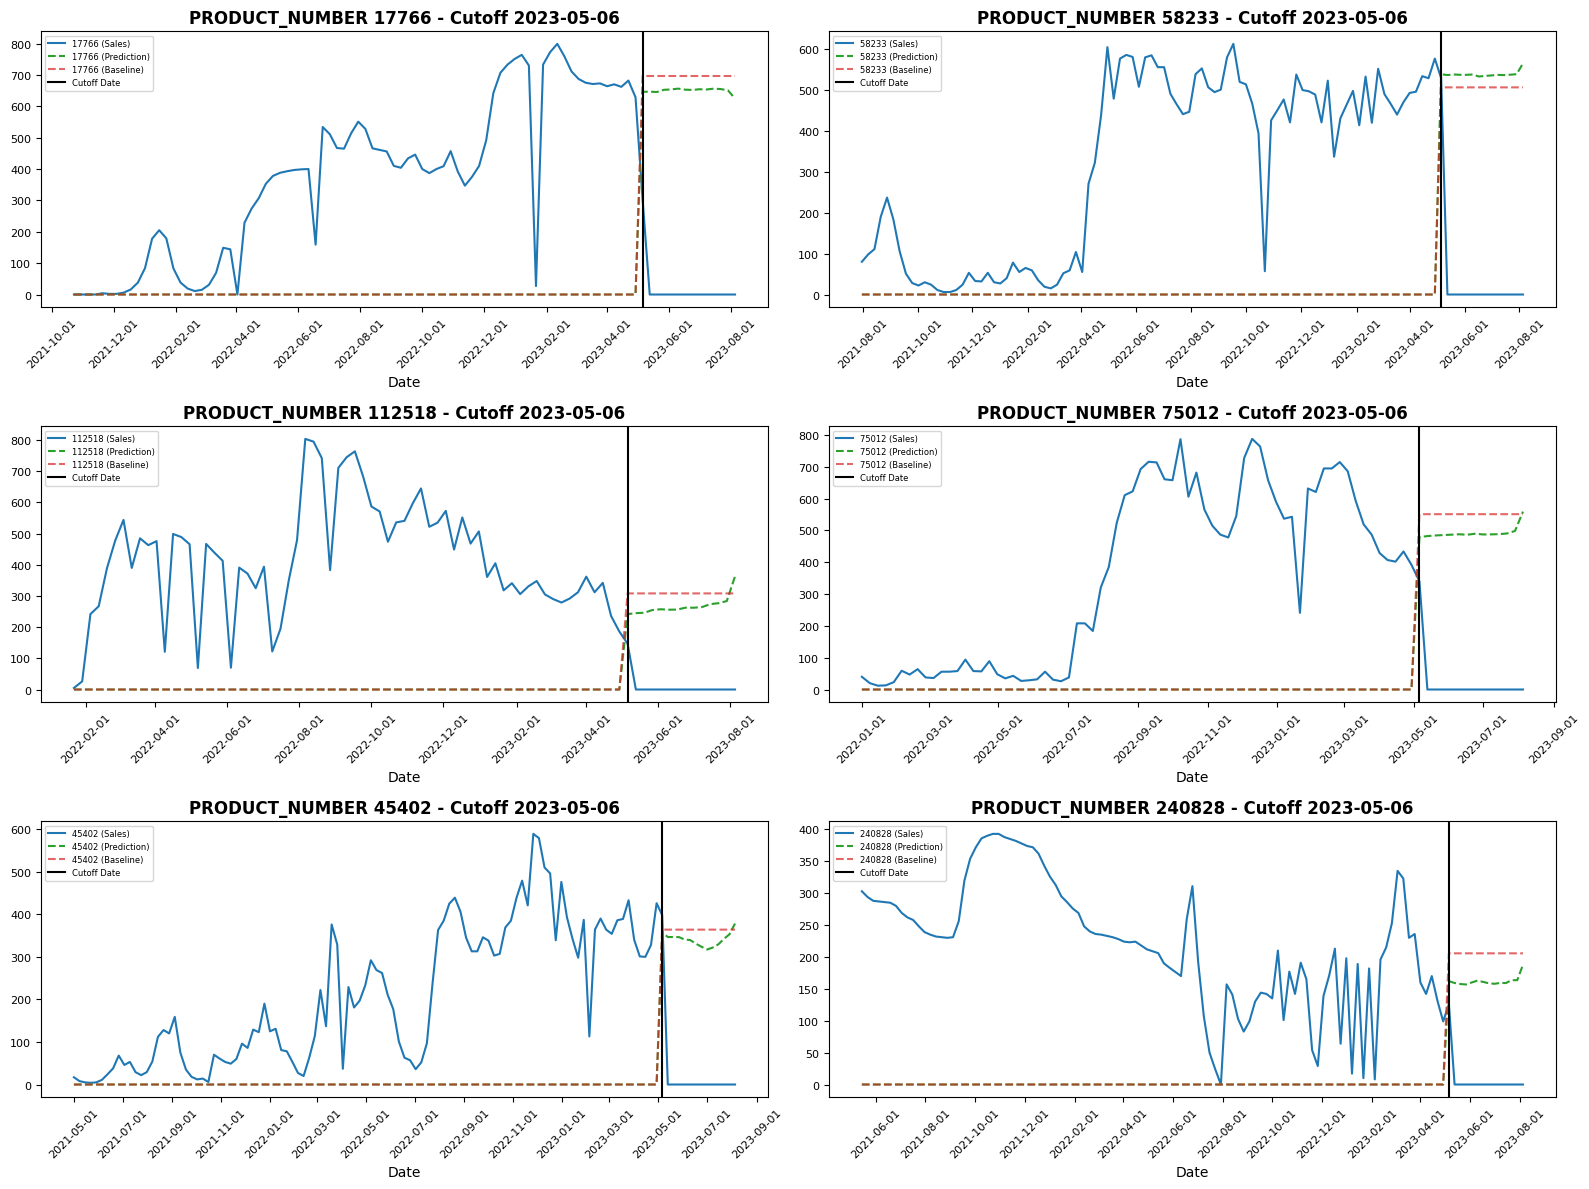

In [23]:
# Plot by product
process_and_plot(
    df_filtered,
    group_col='product_number',
    baseline_col=baseline_col,
    target_col=target_col,
    top_n=top_n_plots,
    title='Top Products Target vs Baseline vs Prediction'
)

# Save output

In [24]:
# Create the filename with the phase appended
file_name = f'Data/df_lightgbm_preds.csv'

# Write the dataframe to the CSV file
df_with_preds.to_csv(file_name, index=False)

# Clean

In [25]:
# Garbage collection
gc.collect()

73321